## EDA

In [25]:
from __future__ import division
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn import cross_validation
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import HTML
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

import re
from HTMLParser import HTMLParser
import datetime
import cPickle as pickle
import seaborn as sns

In [26]:
all_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withindgroup/all2.txt'
tech_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withindgroup/tech_all2.txt'

df1 = pd.read_csv(all_file, sep="|")
df2 = pd.read_csv(tech_file, sep="|")

In [27]:
df = df1.copy()

In [28]:
df.rename(columns={'gender':'gender1'}, inplace=True)
df.rename(columns={'gender_forced':'gender'}, inplace=True)

In [29]:
df['first_name'] = df['first_name'].apply(lambda x:'andrew' if x=='anew' else x)
df.loc[df.first_name.isin(['andrew']), 'gender'] = 'male'

In [5]:
raw_data = {'Dataset': ['Raw', 'Cleaned'],
        'total': [47335, 26850],
        'male': [23980,14664],
        'female': [23355, 12186]}
df = pd.DataFrame(raw_data, columns = ['Dataset', 'total', 'male', 'female'])


In [30]:
df.gender.value_counts()

male      14854
female    11996
Name: gender, dtype: int64

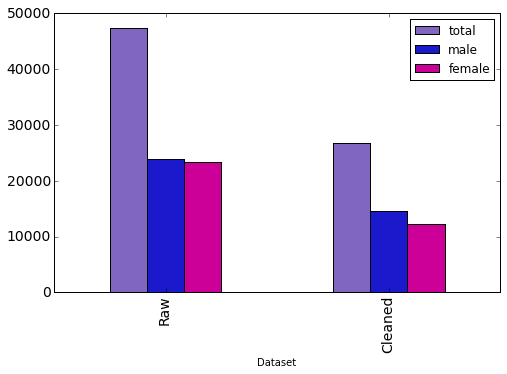

In [18]:
#mycolors = ('g', 'b', 'r')
mycolors = [(0.5,0.4,0.75), (0.1, 0.1, 0.8), (0.8, 0, 0.6)]
df.plot(kind='bar', x=df['Dataset'], fontsize=14, figsize=(8, 5), color=mycolors)

In [364]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26850 entries, 0 to 26849
Data columns (total 24 columns):
first_name          26850 non-null object
full_name           26850 non-null object
html                26850 non-null object
industry            26850 non-null object
location            26850 non-null object
summary             26850 non-null object
title               26850 non-null object
counter             26850 non-null float64
source              26850 non-null object
full_name_fields    26850 non-null object
name_fields         26850 non-null int64
gender              26850 non-null object
gender_type         26850 non-null object
gender_forced       26850 non-null object
name_counts         26850 non-null int64
loc_fields          26850 non-null object
state               26850 non-null object
ind_group           26850 non-null int64
class               26850 non-null int64
summ_tokens         26850 non-null object
num_tokens          26850 non-null int64
summ_missing 

In [365]:
df1.gender_forced.value_counts()

male      14664
female    12186
Name: gender_forced, dtype: int64

In [19]:
df = df1.copy()

In [20]:
df.rename(columns={'gender':'gender1'}, inplace=True)
df.rename(columns={'gender_forced':'gender'}, inplace=True)

In [31]:
# Functions
def missing(df):
    if df.summary == 'missing' or df.num_tokens == 0:
        return 1
    else:
        return 0    


def lenx(mystr):
    return len(mystr.split())


def avgchrs(mytokens):
    tw = len(mytokens)    
    num_chars = 0
    for word in mytokens:
        num_chars += len(word)        
    return num_chars/tw


def remove_digits(mystr):
    '''
    INPUT: list of tokens 
    OUTPUT: list of tokens with digits removed
    '''
    return [word for word in mystr if not word.isdigit()]


stemmer = SnowballStemmer("english")
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def tokenize(text):
    tokens = word_tokenize(text)
    row = remove_digits(tokens)
    stems = stem_tokens(row, stemmer)
    return stems


def tokenize_no_stem(text):
    tokens = word_tokenize(text)
    row = remove_digits(tokens)
    stems = stem_tokens(row, stemmer)
    return tokens 

def get_vocab(input_df):
    tokens_by_row = input_df['summ_tokens']
    vocab = []
    for row in tokens_by_row:
        row = remove_digits(row)
        for word in row:
            if word not in stopwords:
                vocab.append(word) 
    return vocab

def get_vocab_simple(input_df):
    tokens_by_row = input_df['summ_tokens']
    vocab = []
    for row in tokens_by_row:
        row = remove_digits(row)
        for word in row:
            vocab.append(word) 
    return vocab

def preprocess_df(df):
    # Feature Engineering before running the prediction code
    df['class'] = np.ones(len(df))
    df['class'] = df['gender'].apply(lambda x: 0 if x == 'female' else 1)

    df['summ_tokens'] = df['summary'].apply(lambda x: nltk.word_tokenize(str(x)))
    df['num_tokens'] = df['summ_tokens'].apply(lambda x: len(x))

    # Add feature for missing summary
    df['summ_missing'] = df.apply(missing, axis = 1)

    # Only include rows with summaries
    df = df[df['summ_missing'] == 0]

    # Some Nan rows refuse to go without this
    df = df[pd.notnull(df['summary'])]

    print ("Length of DF after removing rows with missing Summaries:\n")
    print (len(df))

    df['avg_len'] = df['summ_tokens'].apply(lambda x: avgchrs(x))

    # lexical diversity = number of unique tokens / total number of tokens
    df['lex_diversity'] = df['summ_tokens'].apply(lambda x: len(set(x))/len(x))
    
    return df

In [376]:
names_cnts = df['first_name'].nunique()

In [377]:
names_cnts

5698

In [32]:
df = preprocess_df(df)

Length of DF after removing rows with missing Summaries:

26850


In [379]:
# For each row, return the total count of the industry that are the same and create a column
ind_cnts = df.groupby('industry').size()
ind_cnts.name = 'ind_cnts'
df = df.set_index('industry').join(ind_cnts).reset_index()

In [243]:
# Plot Gender by Industry for the top 10 industries

In [380]:
top10ind = df.groupby('industry').size().nlargest(10)

In [381]:
dftop10 = df.loc[df['industry'].isin(top10ind.index)]

In [382]:
ordered_ind = list(top10ind.index)

In [384]:
ordered_ind

['higher education',
 'research',
 'information technology and services',
 'computer software',
 'marketing and advertising',
 'hospital   health care',
 'financial services',
 'nonprofit organization management',
 'internet',
 'management consulting']

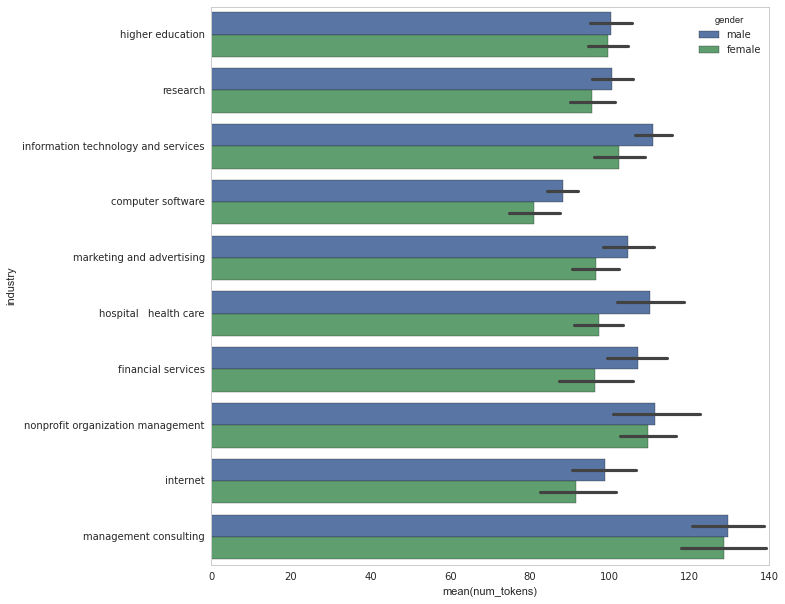

In [385]:
plt.figure(figsize=(10,10))
sns.barplot(x="num_tokens", y="industry", hue="gender", order=ordered_ind, data=dftop10)

In [33]:
# Count of each category
plt.figure(figsize=(10,10))
mycolors = ('b','ffc0cb') 
sns.countplot(y="industry", hue="gender", data=dftop10, order=ordered_ind, palette=mycolors);

####Sort this graph by the total industr count

NameError: name 'dftop10' is not defined

In [342]:
df[df['lex_diversity'] == 1]

,first_name,full_name,html,industry,location,summary,title,counter,source,full_name_fields,...,name_counts,loc_fields,state,ind_group,class,summ_tokens,num_tokens,summ_missing,avg_len,lex_diversity
3,abby,abby mcbride,../../data/raw/2015-12-23-holyoke/abbymcbride....,writing and editing,"portland, maine",abby mcbride is an mittrained science writer ...,Science Writer and Artist,1,holyoke,"['abby', 'mcbride']",...,3,"['portland', 'maine']",ME,3,0,"['abby', 'mcbride', 'is', 'an', 'mittrained', ...",26,0,6.115385,1
12,aldo,aldo santiago,../../data/raw/2015-12-23-holyoke/aldo-santiag...,oil energy,"fresno, texas",utii vtii ptii mtii rti api 578 pmi,ndt /rope access supervisor at CanUsa inc,1,holyoke,"['aldo', 'santiago']",...,1,"['fresno', 'texas']",TX,3,1,"['utii', 'vtii', 'ptii', 'mtii', 'rti', 'api',...",8,0,3.500000,1
41,amanda,amanda baker,../../data/raw/2015-12-23-holyoke/amandabaker....,veterinary,"washington, georgia",specialties collections management paleoclima...,"Experienced Vet Tech Assist, Equestrian and Ex...",1,holyoke,"['amanda', 'baker']",...,17,"['washington', 'georgia']",GA,3,0,"['specialties', 'collections', 'management', '...",6,0,10.166667,1
44,amanda,amanda t stahl,../../data/raw/2015-12-23-holyoke/amandatysons...,higher education,"spokane, washington area",see http fremierlabblogspotcom p peoplehtml,"PhD Student, Environmental & Natural Resource ...",1,holyoke,"['amanda', 't', 'stahl']",...,17,"['spokane', 'washington']",WA,1,0,"['see', 'http', 'fremierlabblogspotcom', 'p', ...",5,0,7.800000,1
58,anea,anea karim,../../data/raw/2015-12-23-holyoke/andrea-karim...,writing and editing,greater seattle area,succinct but catchy copy that hooks readers a...,Copywriter (Contract through Disys) at T-Mobile,1,holyoke,"['anea', 'karim']",...,10,['seattle'],WA,3,0,"['succinct', 'but', 'catchy', 'copy', 'that', ...",12,0,4.916667,1
61,anea,anea sthilaire,../../data/raw/2015-12-23-holyoke/asglenn.html,professional training coaching,"carthage, north carolina",wwwhalcyoneqcom,"Owner, Trainer, Program/Breeding Manager at Ha...",1,holyoke,"['anea', 'sthilaire']",...,10,"['carthage', 'north', 'carolina']",NC,3,0,['wwwhalcyoneqcom'],1,0,15.000000,1
74,anna,anna huntley,../../data/raw/2015-12-23-holyoke/anna-huntley...,government administration,"columbia, south carolina area",using a broad range of communications capabil...,"Communications, Outreach + Media Relations",1,holyoke,"['anna', 'huntley']",...,11,"['columbia', 'south', 'carolina']",SC,3,0,"['using', 'a', 'broad', 'range', 'of', 'commun...",19,0,6.894737,1
95,ashley,ashley chase,../../data/raw/2015-12-23-holyoke/ashley-chase...,education management,greater boston area,behavior specialist autism studies childhood ...,BCBA at Applied Behavioral Learning Services,1,holyoke,"['ashley', 'chase']",...,11,['boston'],MA,3,1,"['behavior', 'specialist', 'autism', 'studies'...",11,0,9.181818,1
125,beth,beth mcguire,../../data/raw/2015-12-23-holyoke/beth-mcguire...,marketing and advertising,greater minneapolis-st. paul area,marketing communications and corporate social...,"VP, Consumer Communication Solutions at United...",1,holyoke,"['beth', 'mcguire']",...,17,"['minneapolisst', 'paul']",MN,3,0,"['marketing', 'communications', 'and', 'corpor...",11,0,8.000000,1
133,bianca,bianca timpano,../../data/raw/2015-12-23-holyoke/bianca-timpa...,health wellness and fitness,"waterford, connecticut",sophomore exercise science major with strong ...,Student at Sacred Heart University,1,holyoke,"['bianca', 'timpano']",...,2,"['waterford', 'connecticut']",CT,3,0,"['sophomore', 'exercise', 'science', 'major', ...",11,0,6.272727,1


In [35]:
females = df[df['gender'] == 'female']
males = df[df['gender'] == 'male']


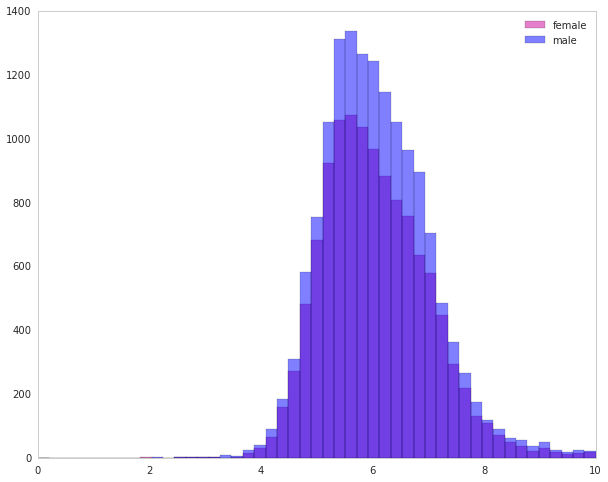

In [37]:
#sns.set_style("dark")
sns.set_style("whitegrid", {'axes.grid' : False})
f_avglen = np.array(females['avg_len'])
m_avglen = np.array(males['avg_len'])
bins = np.linspace(0, 10)
plt.figure(figsize=(10,8))
plt.hist(f_avglen, bins, alpha=0.5, label='female', color=[(0.8, 0, 0.6)])
plt.hist(m_avglen, bins, alpha=0.5, label='male', color='b')
plt.legend(loc='upper right')
plt.show()

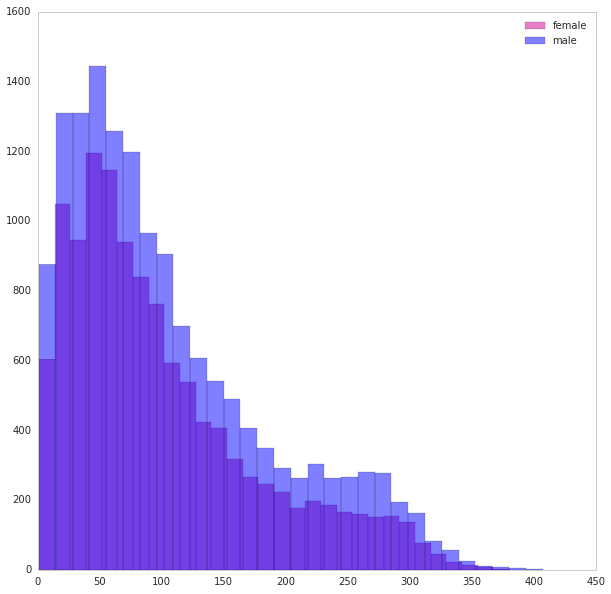

In [38]:
sns.set_style("whitegrid", {'axes.grid' : False})
f_numtokens = np.array(females['num_tokens'])
m_numtokens = np.array(males['num_tokens'])
plt.figure(figsize=(10,10))
plt.hist(f_numtokens, bins=30, alpha=0.5, label='female', color=[(0.8, 0, 0.6)])
plt.hist(m_numtokens, bins=30, alpha=0.5, label='male', color='b')
plt.legend(loc='upper right')
plt.show()

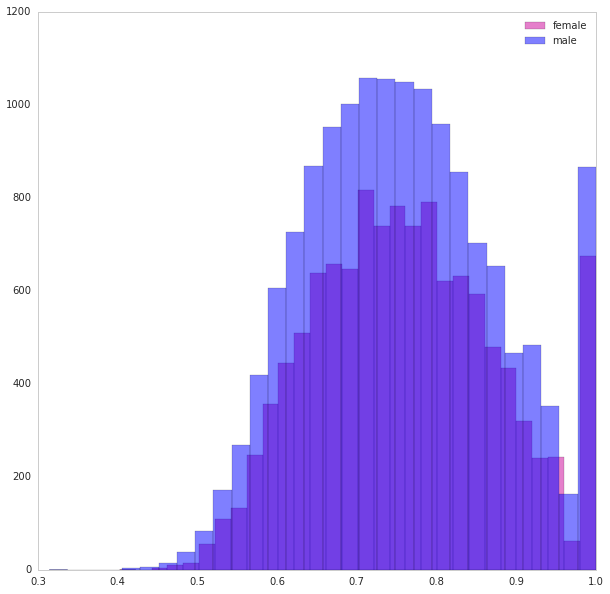

In [39]:
sns.set_style("whitegrid", {'axes.grid' : False})
f_lexd = np.array(females['lex_diversity'])
m_lexd = np.array(males['lex_diversity'])
plt.figure(figsize=(10,10))
plt.hist(f_lexd, bins=30, alpha=0.5, label='female', color=[(0.8, 0, 0.6)])
plt.hist(m_lexd, bins=30, alpha=0.5, label='male', color='b' )
plt.legend(loc='upper right')
plt.show()

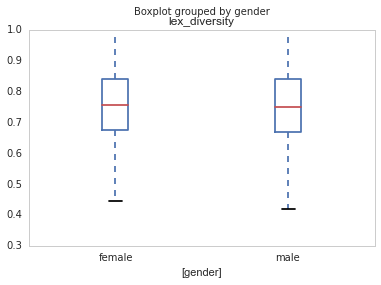

In [401]:
df.boxplot(column=['lex_diversity'], by=['gender'], grid=False)

In [453]:
females = df[df['gender'] == 'female']
males = df[df['gender'] == 'male']

In [448]:
df['first_name'] = df['first_name'].apply(lambda x:'andrew' if x=='anew' else x)

In [451]:
type(df)

pandas.core.frame.DataFrame

In [450]:
df.loc[df.first_name.isin(['andrew']), 'gender'] = 'male'

In [ ]:
# Plots of number of names vs. profiles

In [455]:
# Names and Value Counts
# Female Names
fname_cnts = females['first_name'].value_counts()
fnames = list(fname_cnts.index)
fname_cnts = list(fname_cnts)
fem_names = pd.DataFrame({'names':fnames,'name_cnts':fname_cnts})
fem_names['cum_sum'] = fem_names.name_cnts.cumsum()
fem_names['cum_perc'] = 100*fem_names.cum_sum/fem_names.name_cnts.sum()
fem_names['id'] = np.arange(1, (len(fem_names)+1))
#bins = np.linspace(0, fem_names.cum_perc.max(), 10)
bins = [0, 20, 40, 60, 80]
fem_names['np_ind'] = fem_names['cum_perc'].apply(lambda x: np.digitize(x, bins))

labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-90','90+']

fem_names['bins'] = pd.cut(fem_names['cum_perc'], bins, right=True, include_lowest=False)


#pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)

In [460]:
# Names and Value Counts
# Male Names
mname_cnts = males['first_name'].value_counts()
mnames = list(mname_cnts.index)
mname_cnts = list(mname_cnts)
male_names = pd.DataFrame({'names':mnames,'name_cnts':mname_cnts})
male_names['cum_sum'] = male_names.name_cnts.cumsum()
male_names['cum_perc'] = 100*male_names.cum_sum/male_names.name_cnts.sum()
male_names['id'] = np.arange(1, (len(male_names)+1))
#bins = np.linspace(0, fem_names.cum_perc.max(), 10)
bins = [0, 20, 40, 60, 80]
male_names['np_ind'] = male_names['cum_perc'].apply(lambda x: np.digitize(x, bins))

labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-90','90+']

male_names['bins'] = pd.cut(male_names['cum_perc'], bins, right=True, include_lowest=False)


#pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)


In [456]:
namedf = pd.DataFrame({'names':fnames[0:10],'name_cnts':fname_cnts[0:10]})

In [461]:
male_df = pd.DataFrame({'names':mnames[0:10],'name_cnts':mname_cnts[0:10]})

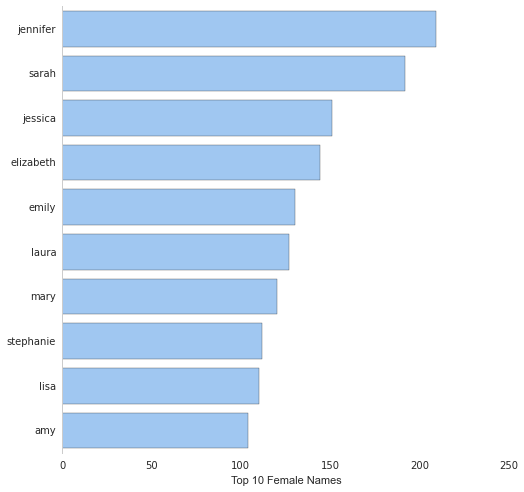

In [466]:
sns.set_style("whitegrid", {'axes.grid' : False})

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8,8))

sns.set_color_codes("pastel")
sns.barplot(x="name_cnts", y="names", data=namedf,
            label="mname_cnts", color="b")

# Add a legend and informative axis label
#ax.legend(ncol=2, loc="center right", frameon=True)
ax.set(ylabel="",
       xlabel="Top 10 Female Names")
sns.despine(right=True, top=True, bottom=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="name_cnts", y="names", data=df,
            label="name_cnts", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="center right", frameon=True)
ax.set(xlim=(0, 600), ylabel="",
       xlabel="Names and their counts")
#sns.despine(right=True, top=True)

In [11]:
plt.plot(kind='bar', df['first_name'].value_counts())

SyntaxError: non-keyword arg after keyword arg (<ipython-input-11-07f68b3e4e5d>, line 1)

In [6]:
df['first_name'].nunique()

6622

In [ ]:
df_agg = df.groupby(['gender','first_name']).agg({'counter':sum})

In [ ]:
#group by the first level of the index
g = df_agg['counter'].groupby(level=0, group_keys=False)

In [ ]:
# sort by the count of the first names
g.nlargest(50)

In [80]:
male_names.head()

,name_cnts,names,cum_sum,cum_perc
0,404,michael,404,2.001883
1,373,david,777,3.850156
2,305,john,1082,5.361479
3,262,jennifer,1344,6.659729
4,261,sarah,1605,7.953025


In [133]:
# Names and Value Counts
# Female Names
fname_cnts = females['first_name'].value_counts()
fnames = list(fname_cnts.index)
fname_cnts = list(fname_cnts)
fem_names = pd.DataFrame({'names':fnames,'name_cnts':fname_cnts})
fem_names['cum_sum'] = fem_names.name_cnts.cumsum()
fem_names['cum_perc'] = 100*fem_names.cum_sum/fem_names.name_cnts.sum()
fem_names['id'] = np.arange(1, (len(fem_names)+1))
#bins = np.linspace(0, fem_names.cum_perc.max(), 10)
bins = [0, 20, 40, 60, 80]
fem_names['np_ind'] = fem_names['cum_perc'].apply(lambda x: np.digitize(x, bins))

labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-90','90+']

fem_names['bins'] = pd.cut(fem_names['cum_perc'], bins, right=True, include_lowest=False)
fem_names['labels'] = pd.cut(fem_names['cum_perc'], bins, labels=labels, right=True, include_lowest=False)


#pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)

In [138]:
sizes = list(fem_names.bins.value_counts())
lables 

In [224]:
bins = [0, 20, 40, 60, 80, 90]
fem_names['np_ind'] = fem_names['cum_perc'].apply(lambda x: np.digitize(x, bins))

In [225]:
name_bins = fem_names.np_ind.value_counts().values
name_bins
type(name_bins)

numpy.ndarray

In [226]:
# Percent of names in each of the five bins
name_pcts = 100 * np.sort(name_bins)/np.sum(name_bins)
name_pcts

array([  0.67272116,   1.64816683,   4.9445005 ,  20.85435587,
        34.07332661,  37.80692903])

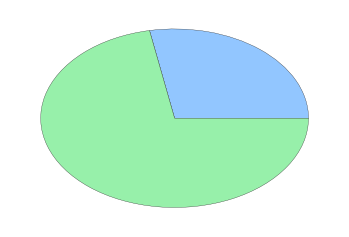

In [223]:
sizes = [28, 72]
labels = ['80%(8,936)', '20%(2,298)']
_= plt.pie(sizes)

In [471]:
females.first_name.nunique()
males.first_name.nunique()

3005

In [220]:
fem_names.groupby(['np_ind']).agg({'cum_perc':max})

,cum_perc
np_ind,
1,19.672423
2,39.896742
3,59.996439
4,79.989318
5,100.000000


In [216]:
fem_names.groupby(['np_ind']).agg({'cum_sum':max})

,cum_sum
np_ind,
1,2210
2,4482
3,6740
4,8986
5,11234


In [217]:
fem_names.groupby(['np_ind']).agg({'name_cnts':sum})

,name_cnts
np_ind,
1,2210
2,2272
3,2258
4,2246
5,2248


In [218]:
fem_names.groupby(['np_ind']).agg({'id':max})

,id
np_ind,
1,20
2,69
3,216
4,836
5,2973


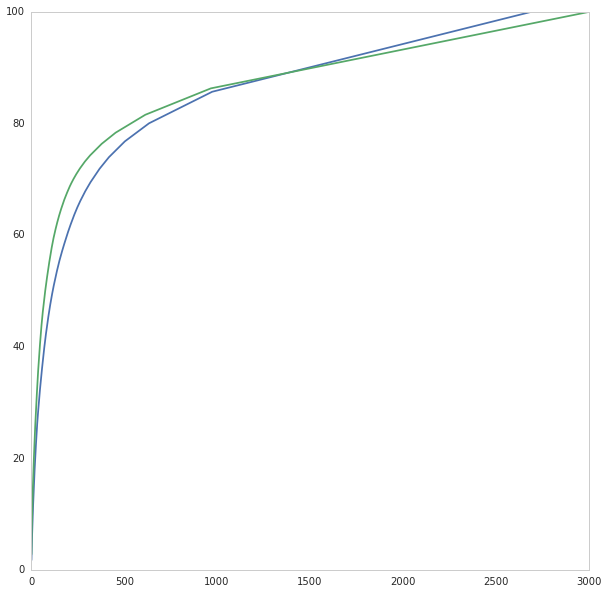

In [468]:
# Plot of name_cnts vs. profiles: Cumsum of Profiles per name
plt.figure(figsize=(10,10));

fem_names['cum_perc'].plot()
male_names['cum_perc'].plot()



In [154]:
fem_names.describe().T

,count,mean,std,min,25%,50%,75%,max
name_cnts,2973,3.778675,11.431556,1.00000,1.000000,1.000000,2.000000,200
cum_sum,2973,9362.571813,1658.990184,200.00000,8802.000000,9748.000000,10491.000000,11234
cum_perc,2973,83.341391,14.767582,1.78031,78.351433,86.772298,93.386149,100
id,2973,1487.000000,858.375501,1.00000,744.000000,1487.000000,2230.000000,2973
np_ind,2973,4.616213,0.717757,1.00000,4.000000,5.000000,5.000000,5


In [152]:
fem_names.head(21)

,name_cnts,names,cum_sum,cum_perc,id,bins,labels,np_ind
0,200,jessica,200,1.780310,1,"(0, 11.111]",10-19,1
1,160,lisa,360,3.204558,2,"(0, 11.111]",10-19,1
2,157,laura,517,4.602101,3,"(0, 11.111]",10-19,1
3,149,stephanie,666,5.928432,4,"(0, 11.111]",10-19,1
4,123,rebecca,789,7.023322,5,"(0, 11.111]",10-19,1
5,123,michelle,912,8.118213,6,"(0, 11.111]",10-19,1
6,114,amanda,1026,9.132989,7,"(0, 11.111]",10-19,1
7,110,steve,1136,10.112160,8,"(0, 11.111]",10-19,1
8,103,katherine,1239,11.029019,9,"(0, 11.111]",10-19,1
9,100,julie,1339,11.919174,10,"(11.111, 22.222]",20-29,1


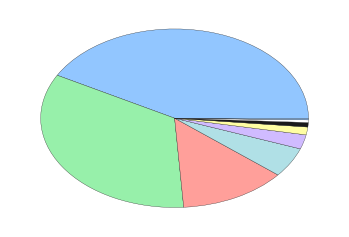

In [141]:
# Pie Chart of Names vs Counts

#sizes = [215, 130, 245, 210]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
# plt.pie(sizes, explode=explode, labels=labels, colors=colors,
#         autopct='%1.1f%%', shadow=True, startangle=140)

_= plt.pie(sizes)

# labels of the pie chart:
# Percentage of Profiles with the top 20% names (9)
# Labels: 20% Names, 40% names, 
# Data: % profiles corresponding to the labels

# Chart 2: Bar Chart of the Top 10 Male Names and Top 10 Female Names in one chart

# Chart 3: 


In [101]:
bins = np.linspace(fem_names.cum_perc.min(), fem_names.cum_perc.max(), 10)
groups = fem_names.groupby(np.digitize(fem_names.cum_perc, bins))

In [142]:
groups

In [112]:
np.arange(1, (len(fem_names)))

array([   1,    2,    3, ..., 2970, 2971, 2972])

In [78]:
fem_names['id'] = np.arange(len(fem_names))

In [ ]:
## Create Bins for the Pie Chart

## Need to create 

df = pandas.DataFrame({"a": np.random.random(100),
                       "b": np.random.random(100),
                       "id": np.arange(100)})

bins = np.linspace(fem_names.cum_perc.min(), fem_names.cum_perc.max(), 20)
groups = fem_names.groupby(np.digitize(fem_names.cum_perc, bins))


In [91]:
fem_names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2973 entries, 0 to 2972
Data columns (total 4 columns):
name_cnts    2973 non-null int64
names        2973 non-null object
cum_sum      2973 non-null int64
cum_perc     2973 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 116.1+ KB


In [92]:
2973/10

297.3

In [79]:
# Male Names
mname_cnts = males['first_name'].value_counts()
mnames = list(mname_cnts.index)
mname_cnts = list(mname_cnts)
male_names = pd.DataFrame({'names':mnames,'name_cnts':mname_cnts})

male_names['cum_sum'] = male_names.name_cnts.cumsum()
male_names['cum_perc'] = 100*male_names.cum_sum/male_names.name_cnts.sum()

#type(f_names)

In [ ]:
## Plot a Pie Chart

# The slices will be ordered and plotted counter-clockwise.

bins = np.linspace(fem_names.cum_perc.min(), fem_names.cum_perc.max(), 20)
groups = fem_names.groupby(np.digitize(fem_names.cum_perc, bins))

labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

fig = plt.figure()
ax = fig.gca()

# Data to plot
labels = 'Python', 'C++', 'Ruby', 'Java'
sizes = [215, 130, 245, 210]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
    
plt.axis('equal')
plt.show()
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Sunny", "Cloudy"])
ax.set_yticklabels(["Dry", "Rainy"])
ax.set_xlim((-0.5, 1.5))
ax.set_ylim((-0.5, 1.5))

# Set aspect ratio to be equal so that pie is drawn as a circle.
ax.set_aspect('equal')

plt.show()

In [81]:
# fig, ax = plt.subplots()
# f_names.plot(ax=ax, kind='bar', alpha = 0.5, figsize=(12,8))

In [8]:
females['first_name'].nunique()

2973

In [9]:
males['first_name'].nunique()

3649

In [ ]:
set(males['first_name'])

In [ ]:
# unique names in females and males
print (females_all['first_name'].nunique())
print (males_all['first_name'].nunique())

In [ ]:
x = zip(fnames, gender_fnames1)
with open('gender1000.txt', 'w') as f:
    for line in x:
        name = line[0]
        g = line[1]
        nameg = name + "," + g + "\n"
        f.write(nameg)
        #f.write("\n")

In [ ]:
letter_freq = df.last_letter.value_counts()
letter_freq.sort_values(ascending=False, inplace=True)


In [ ]:
# Plot one of the features for gender prediction: last letter
fig, ax = plt.subplots()
letter_freq.plot(ax=ax, kind='bar', alpha = 0.5, figsize=(12,8))

In [85]:
df1 = pd.DataFrame({'A' : ['one', 'one', 'two', 'three'] * 3,
                   'B' : np.random.randn(12)})
bins = {'one': (-10,-1,0,1,10), 'two':(-100,0,100), 'three':(-999,0,1,2,3)}

def func(row):
    return pd.cut([row['B']], bins=bins[row['A']])[0]

df1['C'] = df1.apply(func, axis=1)

In [89]:
def binize2(df):
    df['C'] = ''
    for key, values in bins.items():
        mask = df['A'] == key
        df.loc[mask, 'C'] = pd.cut(df.loc[mask, 'B'], bins=values)
    return df

df1 = binize2(df1)

In [90]:
df1

,A,B,C
0,one,0.632204,"(0, 1]"
1,one,-0.621930,"(-1, 0]"
2,two,-0.628475,"(-100, 0]"
3,three,0.219689,"(0, 1]"
4,one,0.528992,"(0, 1]"
5,one,1.064517,"(1, 10]"
6,two,1.232378,"(0, 100]"
7,three,0.312443,"(0, 1]"
8,one,-2.029465,"(-10, -1]"
9,one,-0.531574,"(-1, 0]"


# Practicing Plots

In [143]:
df4 = pd.DataFrame({'a': np.random.randn(1000) + 1, 'b': np.random.randn(1000), 'c': np.random.randn(1000) - 1}, columns=['a', 'b', 'c'])

In [144]:
plt.figure();


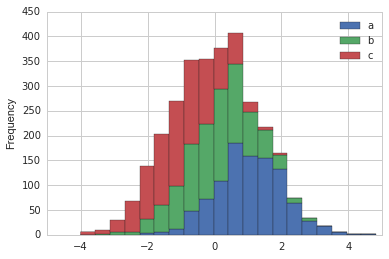

In [145]:
df4.plot(kind='hist', stacked=True, bins=20)

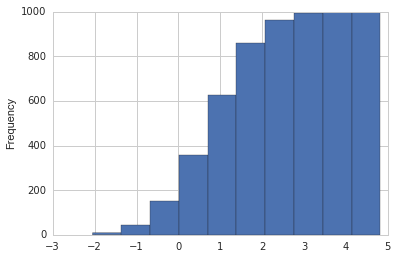

In [146]:
df4['a'].plot(kind='hist', cumulative=True)

In [227]:
43/72

0.5972222222222222

In [294]:
from collections import OrderedDict

import numpy as np

from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.sampledata.les_mis import data

nodes = data['nodes']
names = [node['name'] for node in sorted(data['nodes'], key=lambda x: x['group'])]

N = len(nodes)
counts = np.zeros((N, N))
for link in data['links']:
    counts[link['source'], link['target']] = link['value']
    counts[link['target'], link['source']] = link['value']

In [297]:
len(data)

2

In [298]:
data

{u'links': [{u'source': 1, u'target': 0, u'value': 1},
  {u'source': 2, u'target': 0, u'value': 8},
  {u'source': 3, u'target': 0, u'value': 10},
  {u'source': 3, u'target': 2, u'value': 6},
  {u'source': 4, u'target': 0, u'value': 1},
  {u'source': 5, u'target': 0, u'value': 1},
  {u'source': 6, u'target': 0, u'value': 1},
  {u'source': 7, u'target': 0, u'value': 1},
  {u'source': 8, u'target': 0, u'value': 2},
  {u'source': 9, u'target': 0, u'value': 1},
  {u'source': 11, u'target': 10, u'value': 1},
  {u'source': 11, u'target': 3, u'value': 3},
  {u'source': 11, u'target': 2, u'value': 3},
  {u'source': 11, u'target': 0, u'value': 5},
  {u'source': 12, u'target': 11, u'value': 1},
  {u'source': 13, u'target': 11, u'value': 1},
  {u'source': 14, u'target': 11, u'value': 1},
  {u'source': 15, u'target': 11, u'value': 1},
  {u'source': 17, u'target': 16, u'value': 4},
  {u'source': 18, u'target': 16, u'value': 4},
  {u'source': 18, u'target': 17, u'value': 4},
  {u'source': 19, u'targe